Idea is following:
- The takeaway is that you should not be using smaller networks because you are afraid of overfitting. Instead, you should use as big of a neural network as your computational budget allows, and use other regularization techniques to control overfitting

However, in practice if model become more deep we can see some anomalies

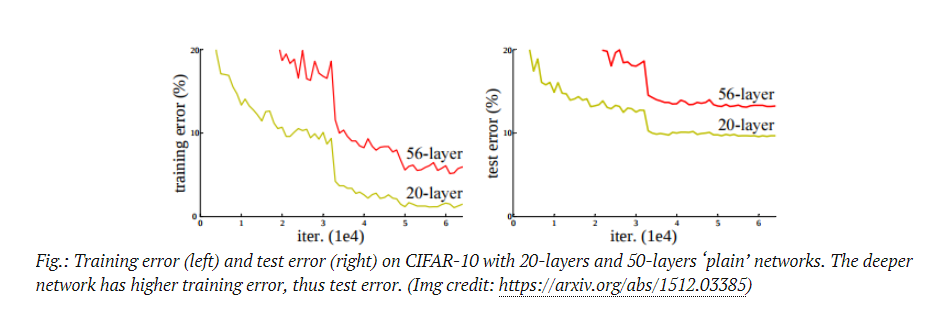

It is well known that increasing the depth leads to exploding or vanishing gradients problem if weights are not initialized properly. In particular, if we have weights bigger than 1, then increasing them at every step of gradient descent will cost us exponential growth which is not good at all. 

However, we can use batch normalization technique to counter this problem

So the problem was that deeper networks cause degradation in convergence and high errors in compare to shallower ones(that have less number of hidden layers)

# ResNet intuition

The idea is how to take shallow networks add some extra layers to make it deeper without losing accuracy or increasing error? We can add identity mappings as extra layers to shallow networks. This is called the solution by construction.

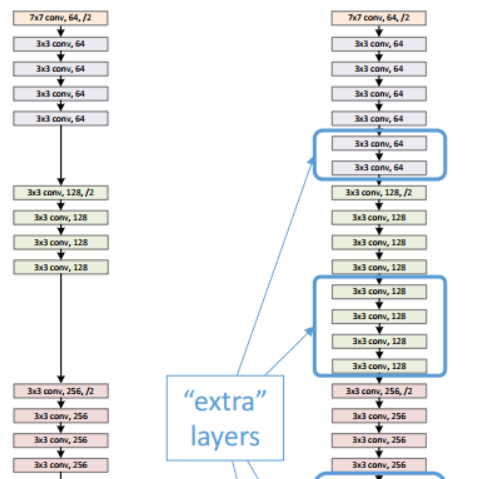

Next step is to understand residual. 

Suppose, you try to guess person's age. The real age is 30. First guess is 25, so now residual error is -5. Next guess is 29, now residual is -1. Next attempt is successfull and residual error is 0. So it is what you should add to your prevoius prediction to match the actual.After we match the actual we shouldn't suppose to do anything. It can be display as following diagram

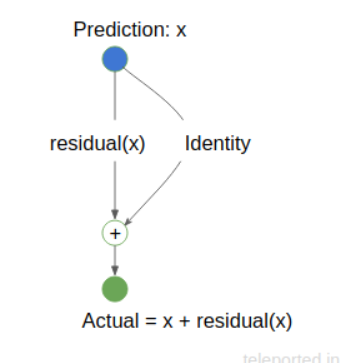


# Residual Network

Next steps are important:
* we want to go deeper without losing accuracy or increasing error. It can be done by injecting identity mappings
* we want be able to learn residuals so that our prediction become closer and closer to actuals

Shortcut connections are those skipping one or more layers. In our case, the shortcut connections simply perform identity mapping, and their outputs are added to the outputs of the stacked layers. Identity shortcut connections add neither extra parameter nor computational complexity. The entire network can still be trained end-to-end by SGD with backpropagation, and can be easily implemented using common libraries without modifying the solvers.

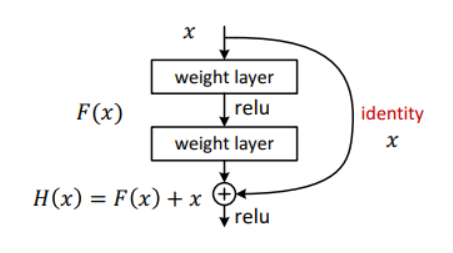

Here H(x) is actual, F(x) is residual, x input

$H(x) = F(x) + x$ , where $F(x) = W2 * Relu(W1*x+b1) + b2$

If $x = H(x)$, then $residual = 0$, so $F(x) = 0$, so this is the case when x is optimal and we don't need more train. But if there is deviation between actual and predicted then weights and biases of F(x) are learned to adjust out predictions to match the actuals.

The great advantage is that if $x = H(x)$ and $F(x) = 0$, then we don't increase learning parameters of our model, we will do that only if $F(x) \neq 0$ to increase accuracy or low error.

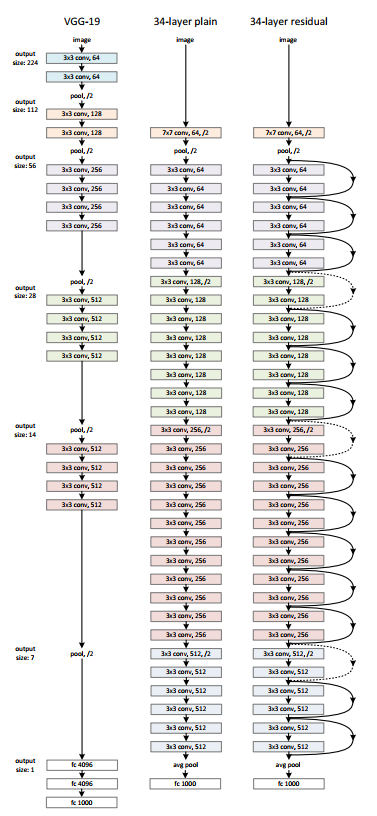

Basic realization using PyTorch.

First, let's write basic BatchNormLayer class

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

We will have Tensor of 3 dimensions(channels, height, width)

In [99]:
class BNLayer(nn.Module):
    def __init__(self,cin,cout):
        super().__init__()
        self.layer = nn.Conv2d(cin,cout,kernel_size =3, stride = 2,bias=False, padding=1) #we can mannualy write kernel and stride in constructor if we'd like
        self.a = nn.Parameter(torch.zeros(cout, 1,1))#parameter to learn shift
        self.m = nn.Parameter(torch.ones(cout, 1,1))#parameter to learn scale
    def forward(self, x):
        #x is data to pass through layer
        x = F.relu(self.layer(x)) 
        x_chan = x.transpose(0,1).contiguous().view(x.size(1),-1)
        self.means = x_chan.mean(1)[:,None,None] # calculate through channels
        self.stds = x_chan.std(1)[:,None,None]
        return (x - self.means)/self.stds * self.m + self.a

In [100]:
l = BNLayer(3, 10)
l

BNLayer(
  (layer): Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
)

In [101]:
x = torch.rand(1,3,32,32)

In [102]:
pred = l(torch.autograd.Variable(x))

In [103]:
pred.shape #10 kernels and 16x16 images

torch.Size([1, 10, 2, 2])

In [145]:
class ConvBNNet(nn.Module):
    def __init__(self, layers , classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList(
        [BNLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        )
        self.out = nn.Linear(layers[-1], classes)
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        x = F.adaptive_max_pool2d(l_x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [146]:
layers = [10, 20, 40, 60 , 80]
net = ConvBNNet(layers , 10)

In [147]:
net

ConvBNNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layers): ModuleList(
    (0): BNLayer(
      (layer): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BNLayer(
      (layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): BNLayer(
      (layer): Conv2d(40, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (3): BNLayer(
      (layer): Conv2d(60, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
  )
  (out): Linear(in_features=80, out_features=10, bias=True)
)

In [165]:
x = torch.autograd.Variable(torch.rand(1,3,128,128) * 3)#imagine one image (1 number #number of images)
#2 number #number of channels, 3d number and 4th width and height of image

In [166]:
pred = net(x)

In [167]:
pred

Variable containing:
-2.2686 -2.2655 -2.3705 -2.2759 -2.2590 -2.4212 -2.2945 -2.2473 -2.3697 -2.2696
[torch.FloatTensor of size 1x10]

In [151]:
import numpy as np

In [152]:
pred = pred.data.numpy()

In [153]:
pred

array([[-2.2685719, -2.2654476, -2.370483 , -2.2757413, -2.2591455,
        -2.4211392, -2.2945988, -2.2472854, -2.3697188, -2.269676 ]],
      dtype=float32)

In [154]:
np.argmax(pred) # winning class

7

# ResNet basic class

In [185]:
class ResNetLayer(BNLayer):
    def forward(self, x):
        return x + super().forward(x) #identity maps + residual

In [237]:
class ResNet(nn.Module):
    def __init__(self, channels, classes,p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.layers1 = nn.ModuleList(
        [BNLayer(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.layers2 = nn.ModuleList(
        [ResNetLayer(channels[i+1], channels[i+1]) for i in range(len(channels)-1)]
        )#adding extra layers
        self.layers3 = nn.ModuleList(
        [ResNetLayer(channels[i+1], channels[i+1]) for i in range(len(channels)-1)]
        )#adding extra layers
        self.out = nn.Linear(channels[-1], classes)
        self.dropout = nn.Dropout(p)
    def forward(self, x):
        x = self.conv1(x)
        for l1,l2,l3 in zip(self.layers1, self.layers2, self.layers3):
            x = l3(F.relu(l2(l1(x))))
        x = F.adaptive_avg_pool2d(x, 1)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.dropout(x)
        return F.log_softmax(self.out(x), dim=-1)
        

In [238]:
x = torch.autograd.Variable(torch.rand(1,3,128,128) * 3)

In [239]:
channels = [16, 32, 64, 128, 256]
resNet = ResNet(channels,10)

In [240]:
resNet

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layers1): ModuleList(
    (0): BNLayer(
      (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BNLayer(
      (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): BNLayer(
      (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (3): BNLayer(
      (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
  )
  (layers2): ModuleList(
    (0): ResNetLayer(
      (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): ResNetLayer(
      (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (2): ResNetLayer(
      (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (3): ResNetLayer(
    

In [241]:
pred = resNet(x)

torch.Size([1, 256, 1, 1])
torch.Size([1, 256])


In [242]:
pred

Variable containing:
-2.2931 -2.3452 -2.3157 -2.2435 -2.2685 -2.3112 -2.3137 -2.3136 -2.3415 -2.2843
[torch.FloatTensor of size 1x10]

In [243]:
np.argmax(pred.data.numpy())

3